In [1]:
import os
import sys
import random
import warnings

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from keras.models import Model, load_model
from keras.layers import Input, Dropout, Lambda, Conv2D, MaxPooling2D, concatenate, Activation, Flatten, Dense
from keras.utils import to_categorical
from keras.optimizers import Adam, RMSprop
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16, preprocess_input

import cv2
import seaborn as sns


import umap

from PIL import Image
from scipy import misc
from os import listdir
from os.path import isfile, join
from random import shuffle
from collections import Counter

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
from plotly import tools

import xgboost as xgb

import tensorflow as tf
from tensorflow.keras.utils import *
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.preprocessing.image import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.losses import *
from tensorflow.keras.callbacks import *

import imutils

from glob import glob

%config Completer.use_jedi = False

import time

from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression

import lightgbm as lgb



In [2]:


init_notebook_mode(connected=True)
RANDOM_SEED = 123

print("All modules have been imported")


All modules have been imported


In [4]:
IMG_PATH = "../1.BrainTumor/Training/dataset"
import shutil
# split the data by train/val/test
ignored = {"pred"}
# split the data by train/val/test
for CLASS in os.listdir(IMG_PATH):
    if CLASS not in ignored:
        if not CLASS.startswith('.'):
            IMG_NUM = len(os.listdir(IMG_PATH +"/"+ CLASS))
            for (n, FILE_NAME) in enumerate(os.listdir(IMG_PATH +"/"+ CLASS)):
                img = IMG_PATH+ '/' +  CLASS + '/' + FILE_NAME
                if n < 300:
                    shutil.copy(img, 'TEST/' + CLASS.upper() + '/' + FILE_NAME)
                elif n < 0.8*IMG_NUM:
                    shutil.copy(img, 'TRAIN/'+ CLASS.upper() + '/' + FILE_NAME)
                else:
                    shutil.copy(img, 'VAL/'+ CLASS.upper() + '/' + FILE_NAME)

In [5]:
def load_data(dir_path, img_size=(100,100)):
    """
    Load resized images as np.arrays to workspace
    """
    X = []
    y = []
    i = 0
    labels = dict()
    for path in tqdm(sorted(os.listdir(dir_path))):
        if not path.startswith('.'):
            labels[i] = path
            for file in os.listdir(dir_path + path):
                if not file.startswith('.'):
                    img = cv2.imread(dir_path + path + '/' + file)
                    X.append(img)
                    y.append(i)
            i += 1
    X = np.array(X)
    y = np.array(y)
    print(f'{len(X)} images loaded from {dir_path} directory.')
    return X, y, labels

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize = (6,6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    cm = np.round(cm,2)
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [6]:
TRAIN_DIR = 'TRAIN/'
TEST_DIR = 'TEST/'
VAL_DIR = 'VAL/'
IMG_SIZE = (224,224)

In [7]:
X_train, y_train, labels = load_data(TRAIN_DIR, IMG_SIZE)
X_test, y_test, _ = load_data(TEST_DIR, IMG_SIZE)
X_val, y_val, _ = load_data(VAL_DIR, IMG_SIZE)
y = dict()
y[0] = []
y[1] = []
for set_name in (y_train, y_val, y_test):
    y[0].append(np.sum(set_name == 0))
    y[1].append(np.sum(set_name == 1))

trace0 = go.Bar(
    x=['Train Set', 'Validation Set', 'Test Set'],
    y=y[0],
    name='No',
    marker=dict(color='#33cc33'),
    opacity=0.7
)
trace1 = go.Bar( x=['Train Set', 'Validation Set', 'Test Set'],
    y=y[1],
    name='Yes',
    marker=dict(color='#ff3300'),
    opacity=0.7
)
data = [trace0, trace1]
layout = go.Layout(
    title='Count of classes in each set',
    xaxis={'title': 'Set'},
    yaxis={'title': 'Count'}
)
fig = go.Figure(data, layout)
iplot(fig)


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:09<00:00,  4.88s/it]
C:\Users\ASUS\AppData\Local\Temp\ipykernel_3284\4189382919.py:18: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



1800 images loaded from TRAIN/ directory.


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.52s/it]


600 images loaded from TEST/ directory.


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.63s/it]


600 images loaded from VAL/ directory.


In [8]:
def plot_samples(X, y, labels_dict, n=50):
    """
    Creates a gridplot for desired number of images (n) from the specified set
    """
    for index in range(len(labels_dict)):
        imgs = X[np.argwhere(y == index)][:n]
        j = 10
        i = int(n/j)

        plt.figure(figsize=(15,6))
        c = 1
        for img in imgs:
            plt.subplot(i,j,c)
            plt.imshow(img[0])

            plt.xticks([])
            plt.yticks([])
            c += 1
        plt.suptitle('Tumor: {}'.format(labels_dict[index]))
        plt.show()

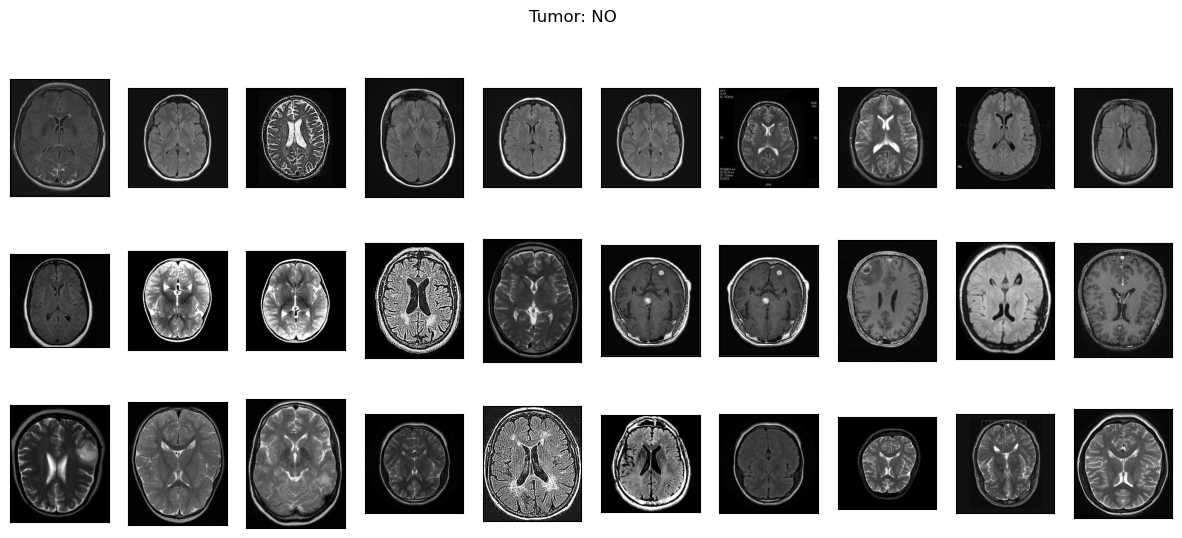

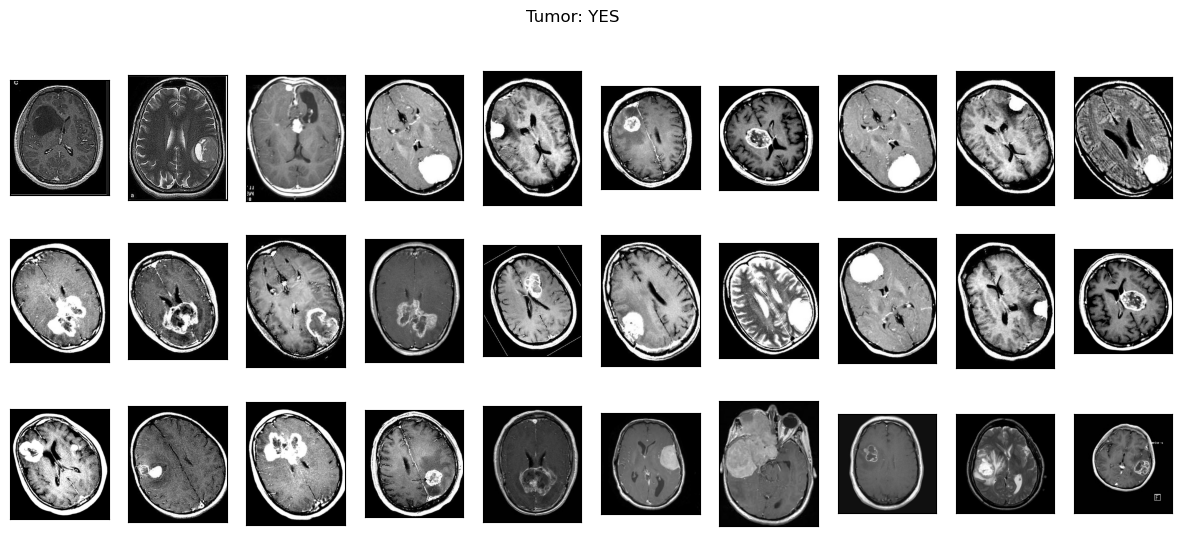

In [9]:
plot_samples(X_train, y_train, labels, 30)

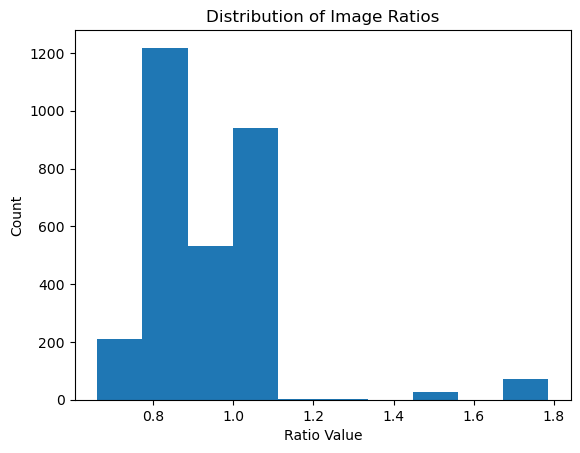

In [10]:
RATIO_LIST = []
for set in (X_train, X_test, X_val):
    for img in set:
        RATIO_LIST.append(img.shape[1]/img.shape[0])
        
plt.hist(RATIO_LIST)
plt.title('Distribution of Image Ratios')
plt.xlabel('Ratio Value')
plt.ylabel('Count')
plt.show()
def crop_imgs(set_name, add_pixels_value=0):
    """
    Finds the extreme points on the image and crops the rectangular out of them
    """
    set_new = []
    for img in set_name:
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        gray = cv2.GaussianBlur(gray, (5, 5), 0)

        # threshold the image, then perform a series of erosions +
        # dilations to remove any small regions of noise
        thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
        thresh = cv2.erode(thresh, None, iterations=2)
        thresh = cv2.dilate(thresh, None, iterations=2)

        # find contours in thresholded image, then grab the largest one
        cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cnts = imutils.grab_contours(cnts)
        c = max(cnts, key=cv2.contourArea)

        # find the extreme points
        extLeft = tuple(c[c[:, :, 0].argmin()][0])
        extRight = tuple(c[c[:, :, 0].argmax()][0])
        extTop = tuple(c[c[:, :, 1].argmin()][0])
        extBot = tuple(c[c[:, :, 1].argmax()][0])

        ADD_PIXELS = add_pixels_value
        new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()
        set_new.append(new_img)

    return np.array(set_new)

In [11]:

img = cv2.imread('./VAL/NO/no852.jpg')
img = cv2.resize(
            img,
            dsize=IMG_SIZE,
            interpolation=cv2.INTER_CUBIC
        )
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
gray = cv2.GaussianBlur(gray, (5, 5), 0)

# threshold the image, then perform a series of erosions +
# dilations to remove any small regions of noise
thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
thresh = cv2.erode(thresh, None, iterations=2)
thresh = cv2.dilate(thresh, None, iterations=2)

# find contours in thresholded image, then grab the largest one
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
c = max(cnts, key=cv2.contourArea)

# find the extreme points
extLeft = tuple(c[c[:, :, 0].argmin()][0])
extRight = tuple(c[c[:, :, 0].argmax()][0])
extTop = tuple(c[c[:, :, 1].argmin()][0])
extBot = tuple(c[c[:, :, 1].argmax()][0])

# add contour on the image
img_cnt = cv2.drawContours(img.copy(), [c], -1, (0, 255, 255), 4)

# add extreme points
img_pnt = cv2.circle(img_cnt.copy(), extLeft, 8, (0, 0, 255), -1)
img_pnt = cv2.circle(img_pnt, extRight, 8, (0, 255, 0), -1)
img_pnt = cv2.circle(img_pnt, extTop, 8, (255, 0, 0), -1)
img_pnt = cv2.circle(img_pnt, extBot, 8, (255, 255, 0), -1)

# crop
ADD_PIXELS = 0
new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()

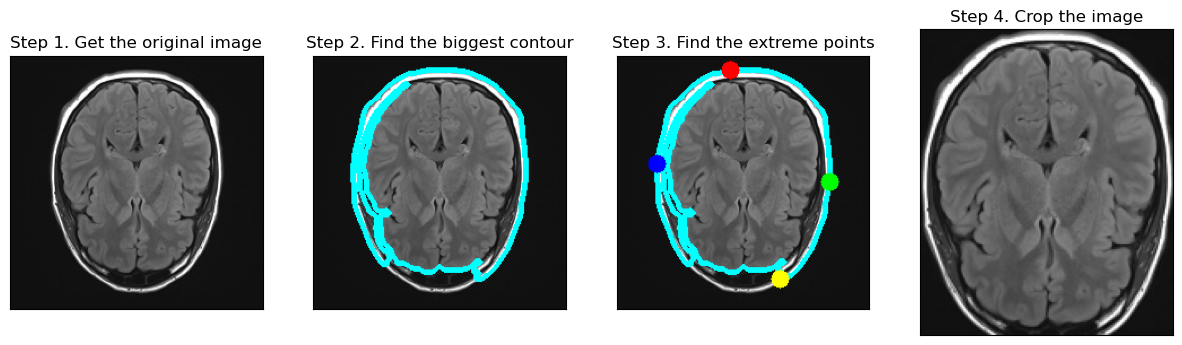

In [12]:
# Let's visualize how the cropping works
plt.figure(figsize=(15,6))
plt.subplot(141)
plt.imshow(img)
plt.xticks([])
plt.yticks([])
plt.title('Step 1. Get the original image')
plt.subplot(142)
plt.imshow(img_cnt)
plt.xticks([])
plt.yticks([])
plt.title('Step 2. Find the biggest contour')
plt.subplot(143)
plt.imshow(img_pnt)
plt.xticks([])
plt.yticks([])
plt.title('Step 3. Find the extreme points')
plt.subplot(144)
plt.imshow(new_img)
plt.xticks([])
plt.yticks([])
plt.title('Step 4. Crop the image')
plt.show()


In [13]:
X_train_crop = crop_imgs(set_name=X_train)
X_val_crop = crop_imgs(set_name=X_val)
X_test_crop = crop_imgs(set_name=X_test)

C:\Users\ASUS\AppData\Local\Temp\ipykernel_3284\1798482230.py:41: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



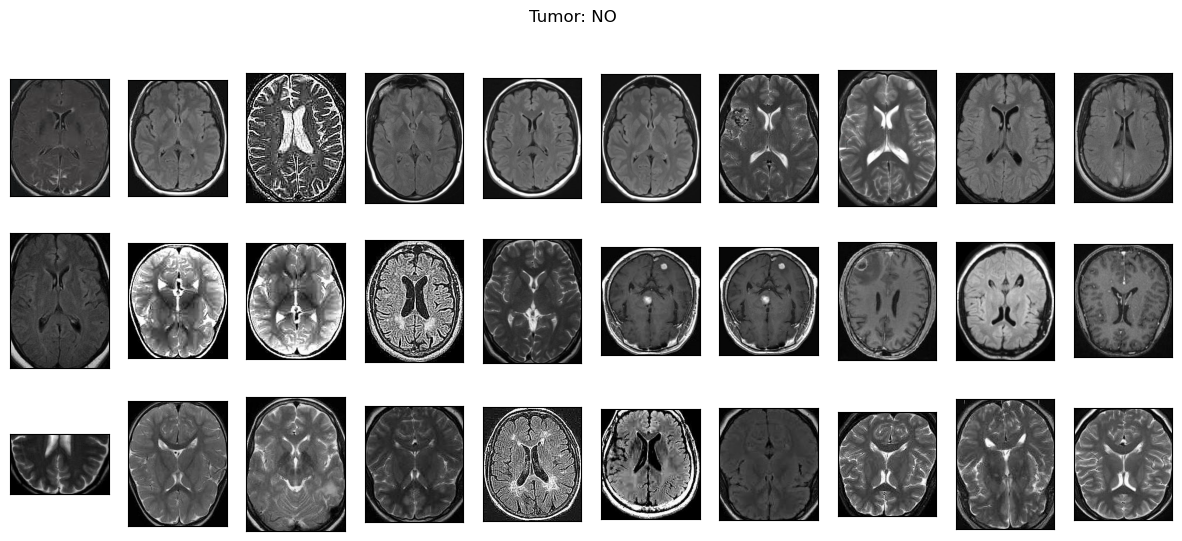

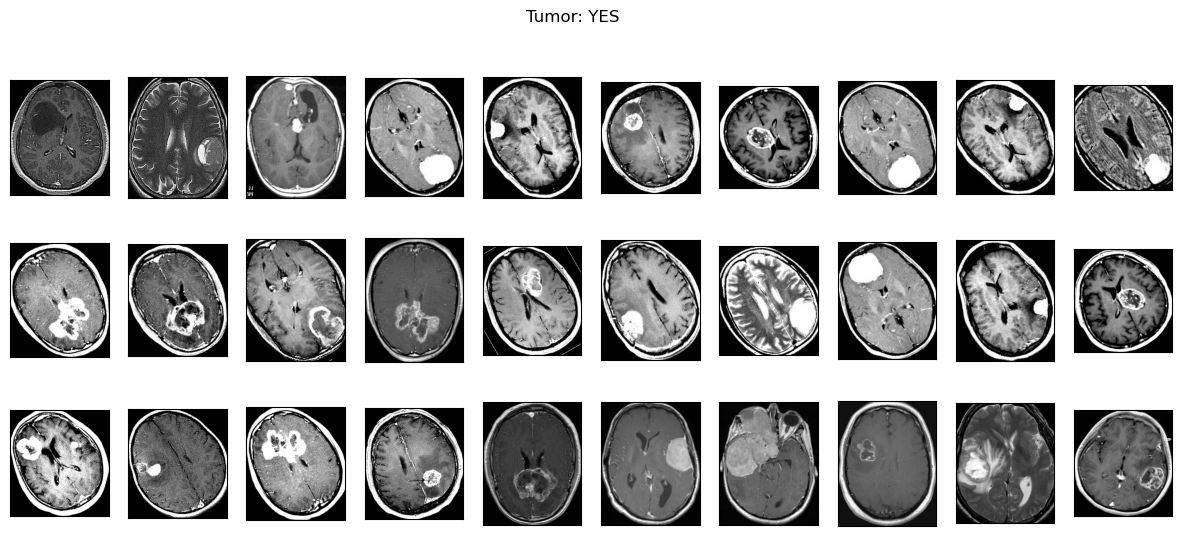

In [14]:
plot_samples(X_train_crop, y_train, labels, 30)

In [15]:
def save_new_images(x_set, y_set, folder_name):
    i = 0
    for (img, imclass) in zip(x_set, y_set):
        if imclass == 0:
            cv2.imwrite(folder_name+'NO/'+str(i)+'.jpg', img)
        else:
            cv2.imwrite(folder_name+'YES/'+str(i)+'.jpg', img)
        i += 1

In [17]:
#Already Created
# import os

# # Create directories if they don't exist
# folders = ['TRAIN_CROP', 'TEST_CROP', 'VAL_CROP', 'TRAIN_CROP/YES', 'TRAIN_CROP/NO', 'TEST_CROP/YES', 'TEST_CROP/NO', 'VAL_CROP/YES', 'VAL_CROP/NO']
# for folder in folders:
#     os.makedirs(folder, exist_ok=True)

# Assuming save_new_images is defined somewhere
save_new_images(X_train_crop, y_train, folder_name='TRAIN_CROP/')
save_new_images(X_val_crop, y_val, folder_name='VAL_CROP/')
save_new_images(X_test_crop, y_test, folder_name='TEST_CROP/')


In [18]:
def preprocess_imgs(set_name, img_size):
    set_new = []
    for img in set_name:
        img = cv2.resize(
            img,
            dsize=img_size,
            interpolation=cv2.INTER_CUBIC
        )
        set_new.append(preprocess_input(img))
    return np.array(set_new)
# Assuming you have defined the preprocess_input function elsewhere
IMG_SIZE = (224, 224)  # Define the desired image size
X_train_prep = preprocess_imgs(set_name=X_train_crop, img_size=IMG_SIZE)
X_test_prep = preprocess_imgs(set_name=X_test_crop, img_size=IMG_SIZE)
X_val_prep = preprocess_imgs(set_name=X_val_crop, img_size=IMG_SIZE)


In [ ]:
#Preprocessoing

In [ ]:
plot_samples(X_train_prep, y_train, labels, 30)

In [ ]:
#Augmentation


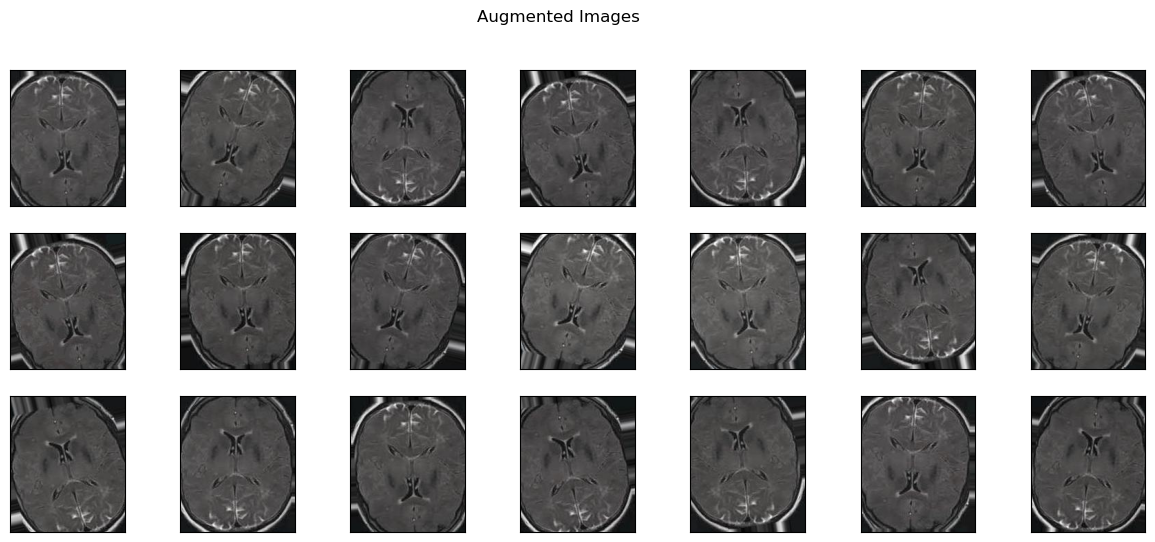

In [32]:
import os
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

demo_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.05,
    height_shift_range=0.05,
    rescale=1./255,
    shear_range=0.05,
    brightness_range=[0.1, 1.5],
    horizontal_flip=True,
    vertical_flip=True
)

os.makedirs('preview', exist_ok=True)

x = X_train_crop[0]  
x = x.reshape((1,) + x.shape) 

i = 0
for batch in demo_datagen.flow(x, batch_size=1, save_to_dir='preview', save_prefix='aug_img', save_format='jpg'):
    i += 1
    if i > 20:
        break 

plt.figure(figsize=(15, 6))
i = 1
for img_name in os.listdir('preview/'):
    img = cv2.imread(os.path.join('preview', img_name))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(3, 7, i)
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    i += 1
    if i > 3*7:
        break

plt.suptitle('Augmented Images')
plt.show()


In [33]:
rmdir /s /q preview

In [34]:
TRAIN_DIR = 'TRAIN_CROP/'
VAL_DIR = 'VAL_CROP/'
RANDOM_SEED = 42
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    brightness_range=[0.5, 1.5],
    horizontal_flip=True,
    vertical_flip=True,
    preprocessing_function=preprocess_input
)

test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)


train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    color_mode='rgb',
    target_size=IMG_SIZE,
   
    batch_size=32,
    class_mode='binary',
    seed=RANDOM_SEED
)


validation_generator = test_datagen.flow_from_directory(
    VAL_DIR,
    color_mode='rgb',
    target_size=IMG_SIZE,
    batch_size=16,
    class_mode='binary',
    seed=RANDOM_SEED
)


Found 1800 images belonging to 2 classes.
Found 600 images belonging to 2 classes.


In [ ]:
# from keras.applications.vgg16 import VGG16

# # Load the VGG16 base model pre-trained on ImageNet data
# vgg = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# # Summary of the VGG16 base model
# vgg.summary()



In [35]:
from keras.applications import VGG16
from keras.models import Sequential
from keras.layers import Dense, Flatten, BatchNormalization, Dropout, Activation
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam

from keras.applications import VGG16


base_Neural_Net= VGG16(input_shape=(224,224,3), weights='imagenet', include_top=False)
model=Sequential()
model.add(base_Neural_Net)
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(256,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1,activation='sigmoid'))

for layer in base_Neural_Net.layers:
    layer.trainable = False

    
model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy' , 'AUC']
)

model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 batch_normalization (Batch  (None, 25088)             100352    
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 256)               6422784   
                                                                 
 batch_normalization_1 (Bat  (None, 256)               1024      
 chNormalization)                                                
                                                                 
 activation (Activation)     (None, 256)               0

In [38]:
import time

start_time = time.time()

EPOCHS = 30
es = EarlyStopping(
    monitor='val_accuracy',  
    mode='max',
    patience=6
)

history = model.fit(
    train_generator,
    steps_per_epoch=50,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=25,
    callbacks=[es]
)

end_time = time.time()
total_training_time = end_time - start_time
average_time_per_epoch = total_training_time / EPOCHS

print(f"Total training time: {total_training_time} seconds")
print(f"Average time per epoch: {average_time_per_epoch} seconds")


Epoch 1/30
50/50 [==============================] - 165s 3s/step - loss: 0.3060 - accuracy: 0.8731 - auc: 0.9443 - val_loss: 0.1388 - val_accuracy: 0.9688 - val_auc: 0.9896
Epoch 2/30
50/50 [==============================] - 161s 3s/step - loss: 0.2435 - accuracy: 0.9112 - auc: 0.9645 - val_loss: 0.1541 - val_accuracy: 0.9688 - val_auc: 0.9843
Epoch 3/30
50/50 [==============================] - 157s 3s/step - loss: 0.1982 - accuracy: 0.9239 - auc: 0.9755 - val_loss: 0.0191 - val_accuracy: 1.0000 - val_auc: 1.0000
Epoch 4/30
50/50 [==============================] - 161s 3s/step - loss: 0.1384 - accuracy: 0.9486 - auc: 0.9883 - val_loss: 0.0306 - val_accuracy: 0.9688 - val_auc: 1.0000
Epoch 5/30
50/50 [==============================] - 168s 3s/step - loss: 0.1361 - accuracy: 0.9448 - auc: 0.9888 - val_loss: 0.0176 - val_accuracy: 1.0000 - val_auc: 1.0000
Epoch 6/30
50/50 [==============================] - 166s 3s/step - loss: 0.1258 - accuracy: 0.9549 - auc: 0.9907 - val_loss: 0.0561 - v

In [39]:
history


In [40]:
history.params

{'verbose': 1, 'epochs': 30, 'steps': 50}

In [41]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'auc', 'val_loss', 'val_accuracy', 'val_auc'])

In [42]:
type(history.history['loss'])


list

In [43]:
history.history['loss'][:10]

[0.3060283362865448,
 0.24352715909481049,
 0.19815653562545776,
 0.1383655071258545,
 0.13608744740486145,
 0.12576088309288025,
 0.11330659687519073,
 0.0982753187417984,
 0.10558054596185684]

In [44]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

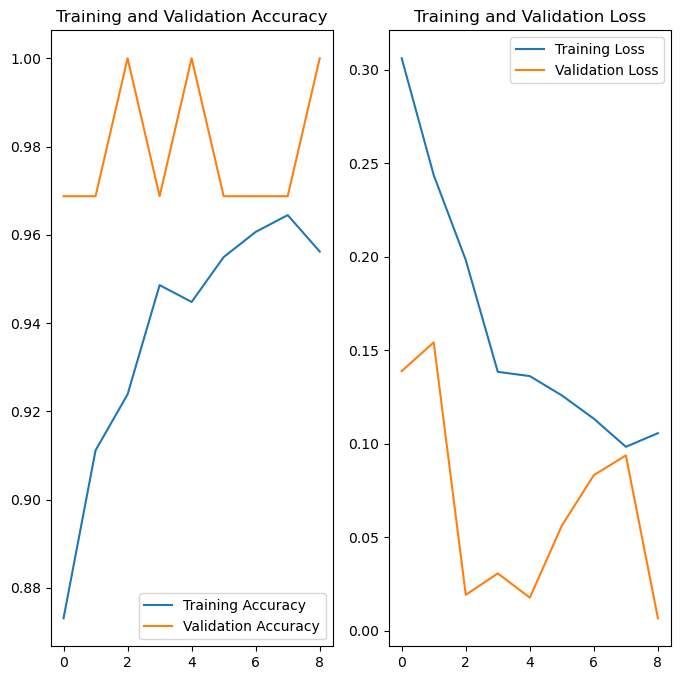

In [47]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(9), acc, label='Training Accuracy')
plt.plot(range(9), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(9), loss, label='Training Loss')
plt.plot(range(9), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

57/57 [==============================] - 190s 3s/step
Train Accuracy = 0.99


NameError: name 'itertools' is not defined

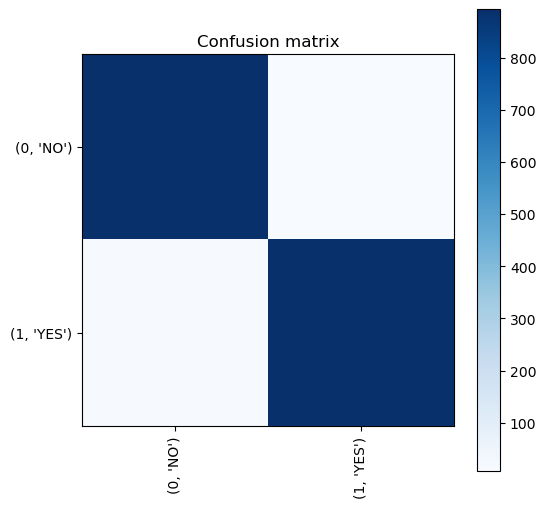

In [48]:
predictions = model.predict(X_train_prep)
predictions = [1 if x>0.5 else 0 for x in predictions]

accuracy = accuracy_score(y_train, predictions)
print('Train Accuracy = %.2f' % accuracy)

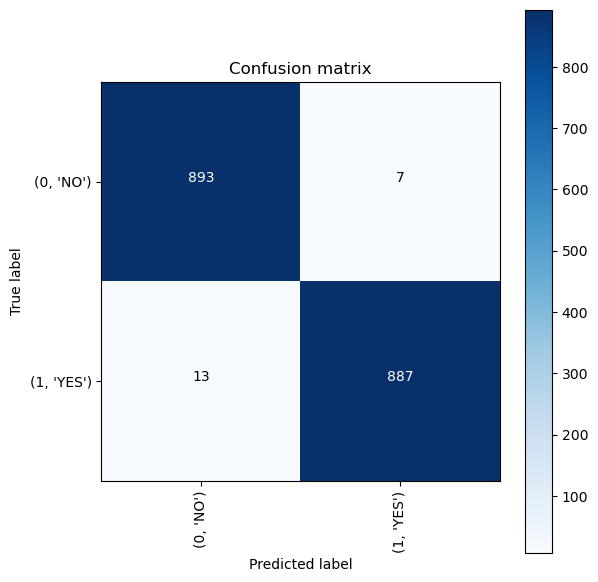

In [49]:

import itertools

confusion_mtx = confusion_matrix(y_train, predictions) 
cm = plot_confusion_matrix(confusion_mtx, classes = list(labels.items()), normalize=False)

19/19 [==============================] - 56s 3s/step
Test Accuracy = 0.99


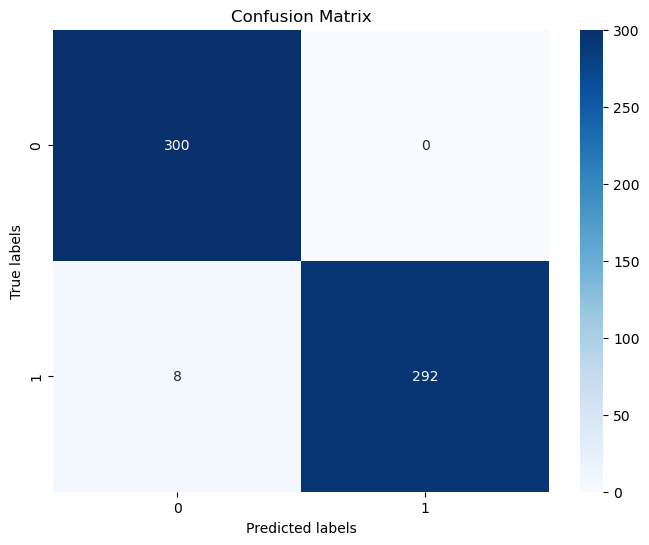

In [50]:
# Validate on the test set
predictions = model.predict(X_test_prep)

# Converting the predictions to binary values based on a threshold (0.5 in this case)
binary_predictions = [1 if pred > 0.5 else 0 for pred in predictions]

# Calculating accuracy
accuracy = accuracy_score(y_test, binary_predictions)
print('Test Accuracy = %.2f' % accuracy)

# Generating and displaying the confusion matrix
confusion_mtx = confusion_matrix(y_test, binary_predictions) 
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mtx, annot=True, fmt='g', cmap='Blues', 
            xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()



19/19 [==============================] - 56s 3s/step
Val Accuracy = 0.98


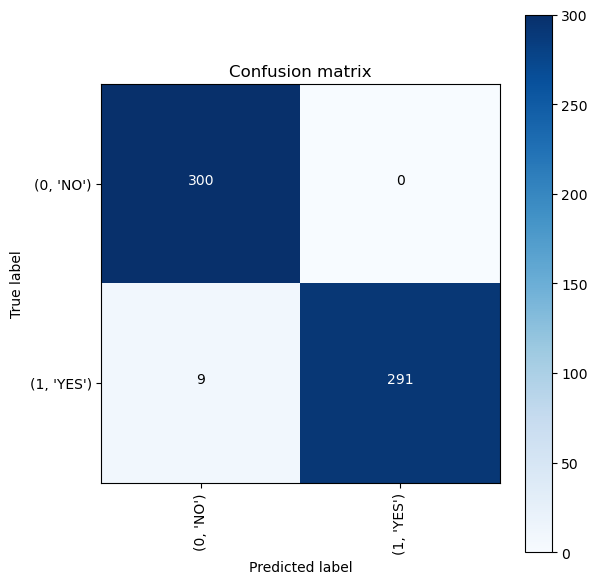

In [51]:
predictions = model.predict(X_val_prep)
predictions = [1 if x>0.5 else 0 for x in predictions]

accuracy = accuracy_score(y_val, predictions)
print('Val Accuracy = %.2f' % accuracy)

confusion_mtx = confusion_matrix(y_val, predictions) 
cm = plot_confusion_matrix(confusion_mtx, classes = list(labels.items()), normalize=False)

In [ ]:
#Model no:7

In [53]:

model_version=max([int(i) for i in os.listdir("models") + [0]])+1
model.save(f"models/{model_version}")

INFO:tensorflow:Assets written to: models/7\assets


INFO:tensorflow:Assets written to: models/7\assets


In [54]:


start_time2 = time.time()

EPOCHS2 = 30


history2 = model.fit(
    train_generator,
    steps_per_epoch=50,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=25,
    
)

end_time2 = time.time()
total_training_time2 = end_time - start_time
average_time_per_epoch2 = total_training_time / EPOCHS

print(f"Total training time: {total_training_time2} seconds")
print(f"Average time per epoch: {average_time_per_epoch2} seconds")


Epoch 1/30
50/50 [==============================] - 191s 4s/step - loss: 0.1170 - accuracy: 0.9581 - auc: 0.9908 - val_loss: 0.0534 - val_accuracy: 0.9775 - val_auc: 0.9999
Epoch 2/30
50/50 [==============================] - 193s 4s/step - loss: 0.1092 - accuracy: 0.9562 - auc: 0.9928 - val_loss: 0.0326 - val_accuracy: 0.9900 - val_auc: 0.9999
Epoch 3/30
50/50 [==============================] - 194s 4s/step - loss: 0.1044 - accuracy: 0.9638 - auc: 0.9929 - val_loss: 0.0500 - val_accuracy: 0.9800 - val_auc: 0.9998
Epoch 4/30
50/50 [==============================] - 204s 4s/step - loss: 0.0831 - accuracy: 0.9676 - auc: 0.9959 - val_loss: 0.0542 - val_accuracy: 0.9800 - val_auc: 0.9992
Epoch 5/30
50/50 [==============================] - 190s 4s/step - loss: 0.0811 - accuracy: 0.9734 - auc: 0.9959 - val_loss: 0.0614 - val_accuracy: 0.9800 - val_auc: 0.9993
Epoch 6/30
50/50 [==============================] - 205s 4s/step - loss: 0.0641 - accuracy: 0.9753 - auc: 0.9978 - val_loss: 0.0670 - v

In [56]:
acc = history2.history['accuracy']
val_acc = history2.history['val_accuracy']

loss = history2.history['loss']
val_loss = history2.history['val_loss']

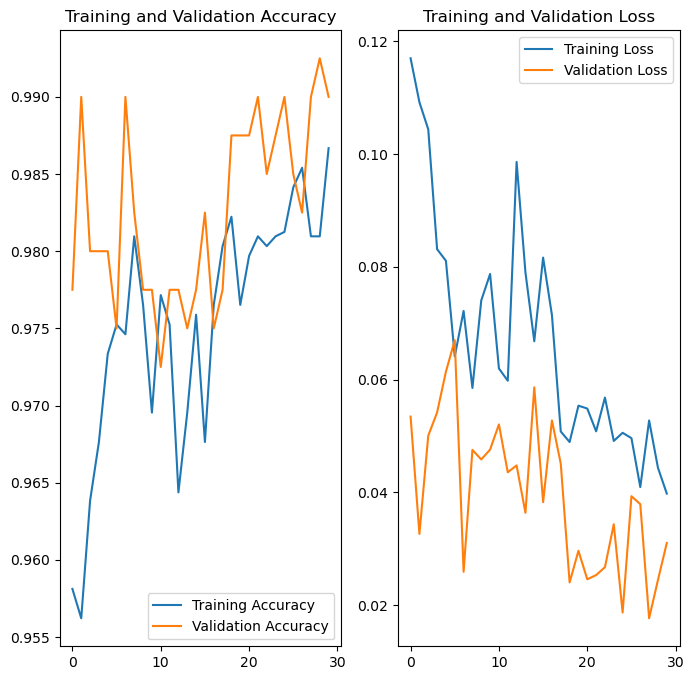

In [58]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [59]:
history2.history['loss'][:30]

[0.11700471490621567,
 0.10920153558254242,
 0.10439892113208771,
 0.08312442898750305,
 0.08107274770736694,
 0.0641157403588295,
 0.07217533886432648,
 0.05850202217698097,
 0.07403404265642166,
 0.07873190939426422,
 0.0619552843272686,
 0.059789493680000305,
 0.09861717373132706,
 0.07902847230434418,
 0.06679470092058182,
 0.08163530379533768,
 0.07143176347017288,
 0.05077730491757393,
 0.04890859127044678,
 0.05535822734236717,
 0.05485223978757858,
 0.05080905184149742,
 0.05679786950349808,
 0.04910086467862129,
 0.05054778978228569,
 0.04959334805607796,
 0.040917083621025085,
 0.05272936448454857,
 0.044341474771499634,
 0.03976292908191681]

In [60]:
history2.history['accuracy'][:30]

[0.9581218361854553,
 0.9562183022499084,
 0.9638324975967407,
 0.9676395654678345,
 0.9733502268791199,
 0.9752538204193115,
 0.9746192693710327,
 0.9809644818305969,
 0.9765228629112244,
 0.9695431590080261,
 0.9771573543548584,
 0.9752538204193115,
 0.9643750190734863,
 0.9695431590080261,
 0.9758883118629456,
 0.9676395654678345,
 0.9765228629112244,
 0.9803299307823181,
 0.9822335243225098,
 0.9765228629112244,
 0.9796954393386841,
 0.9809644818305969,
 0.9803299307823181,
 0.9809644818305969,
 0.981249988079071,
 0.9841370582580566,
 0.9854061007499695,
 0.9809644818305969,
 0.9809644818305969,
 0.9866751432418823]

In [61]:
predictions = model.predict(X_train_prep)
predictions = [1 if x>0.5 else 0 for x in predictions]

accuracy = accuracy_score(y_train, predictions)
print('Train Accuracy = %.2f' % accuracy)

57/57 [==============================] - 195s 3s/step
Train Accuracy = 1.00


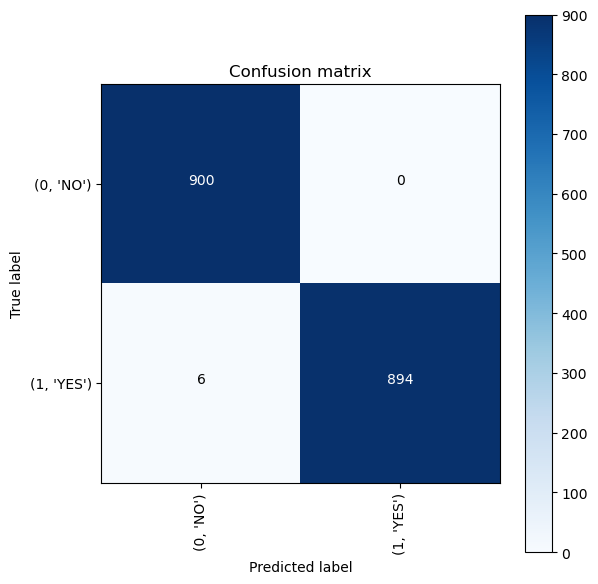

In [64]:


confusion_mtx = confusion_matrix(y_train, predictions) 
cm = plot_confusion_matrix(confusion_mtx, classes = list(labels.items()), normalize=False)

19/19 [==============================] - 52s 3s/step
Test Accuracy = 0.97


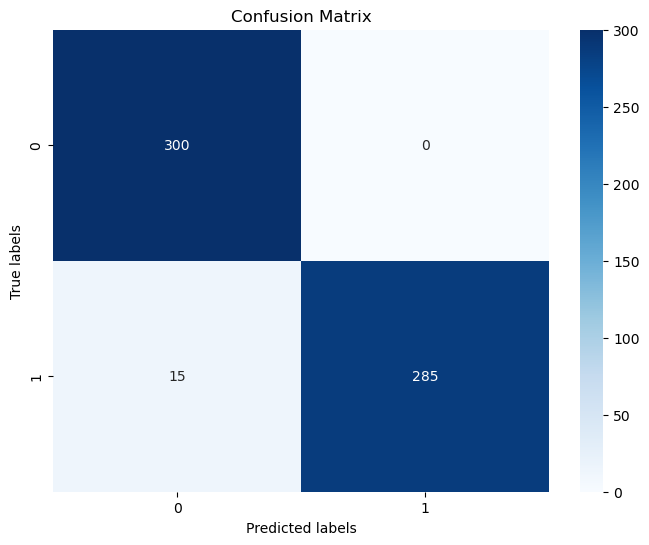

In [65]:
# Validate on the test set
predictions = model.predict(X_test_prep)

# Converting the predictions to binary values based on a threshold (0.5 in this case)
binary_predictions = [1 if pred > 0.5 else 0 for pred in predictions]

# Calculating accuracy
accuracy = accuracy_score(y_test, binary_predictions)
print('Test Accuracy = %.2f' % accuracy)

# Generating and displaying the confusion matrix
confusion_mtx = confusion_matrix(y_test, binary_predictions) 
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mtx, annot=True, fmt='g', cmap='Blues', 
            xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()



19/19 [==============================] - 54s 3s/step
Val Accuracy = 0.98


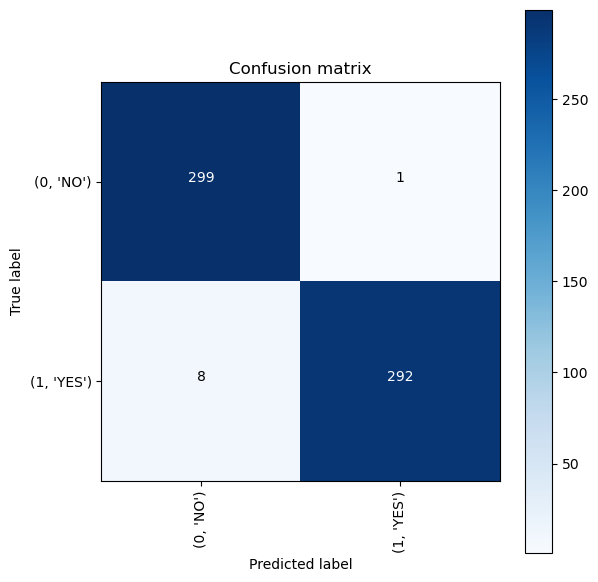

In [66]:
predictions = model.predict(X_val_prep)
predictions = [1 if x>0.5 else 0 for x in predictions]

accuracy = accuracy_score(y_val, predictions)
print('Val Accuracy = %.2f' % accuracy)

confusion_mtx = confusion_matrix(y_val, predictions) 
cm = plot_confusion_matrix(confusion_mtx, classes = list(labels.items()), normalize=False)

In [67]:
#Model 8
model_version=max([int(i) for i in os.listdir("models") + [0]])+1
model.save(f"models/{model_version}")

INFO:tensorflow:Assets written to: models/8\assets


INFO:tensorflow:Assets written to: models/8\assets


In [69]:
!pip install lime


Defaulting to user installation because normal site-packages is not writeable
     ------------------------------------- 275.7/275.7 kB 77.9 kB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283846 sha256=3cbc429489bf3eb1b167dfe440169f41059045ac9e607d900362e0e929fb95a8
  Stored in directory: c:\users\asus\appdata\local\pip\cache\wheels\ac\fc\ba\bc2e218408e730b7ad32dc45fbaa1ae6f0ab314e581101bdff
Successfully built lime


In [70]:
import lime
from lime import lime_image
from lime.wrappers.scikit_image import SegmentationAlgorithm
import matplotlib.pyplot as plt

# Assuming 'model' is your trained model and 'X_test_prep' is your preprocessed test data
explainer = lime_image.LimeImageExplainer()

# Choose an instance for explanation (let's assume the first instance)
instance = X_test_prep[0]

# Get the explanation
explanation = explainer.explain_instance(instance, model.predict, top_labels=5, hide_color=0, num_samples=1000)



  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 1s 1s/step


NameError: name 'mark_boundaries' is not defined

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 1s 1s/step


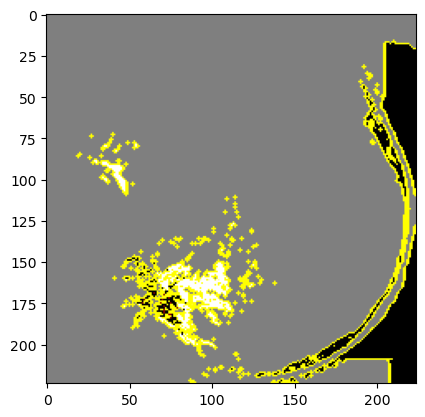

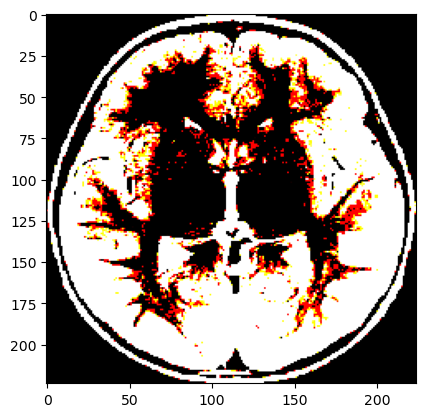

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 1s 998ms/step


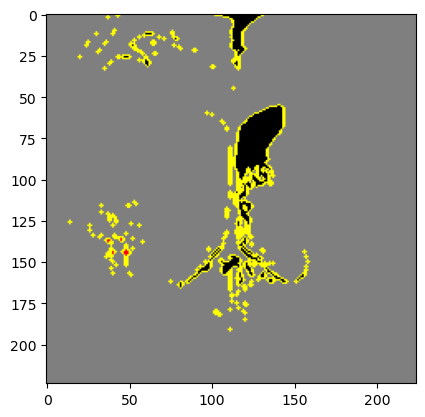

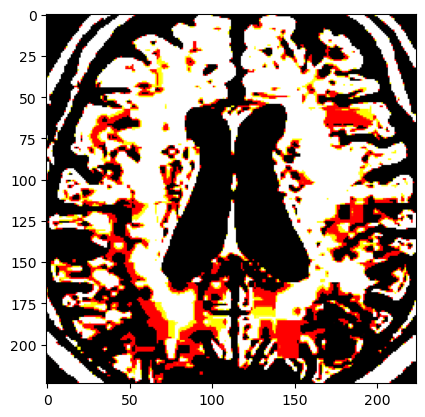

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 1s 1s/step


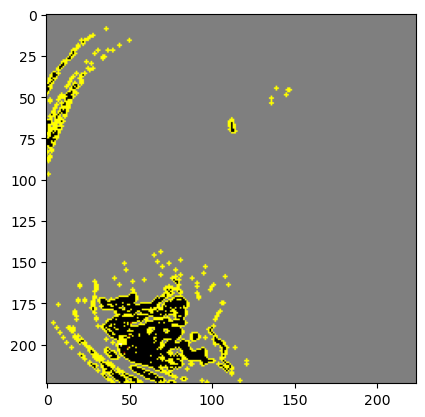

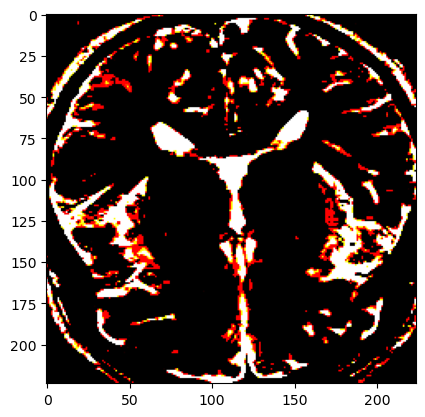

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 1s 920ms/step


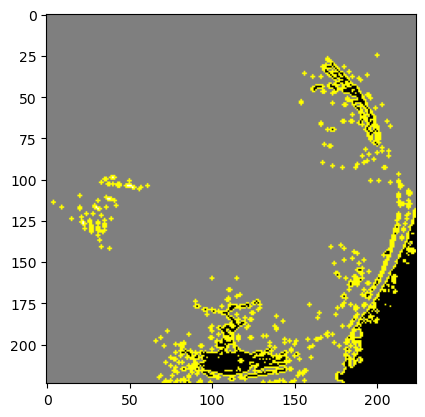

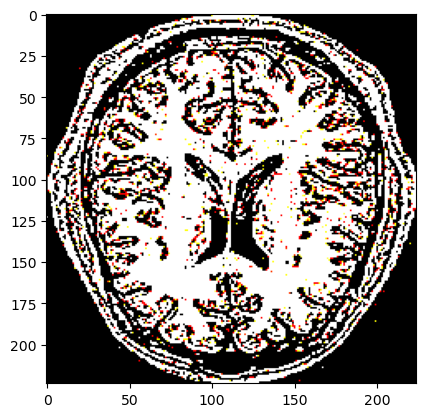

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 1s 952ms/step


KeyboardInterrupt: 

In [75]:
# Assuming 'model' is your trained model and 'X_test_prep' is your preprocessed test data
explainer = lime_image.LimeImageExplainer()

# Iterating over the first five instances
for i in range(5):
    instance = X_test_prep[i]  # Assuming X_test_prep is your preprocessed test data

    # Get the explanation
    explanation = explainer.explain_instance(instance, model.predict, top_labels=5, hide_color=0, num_samples=1000)

    # Show the results in the form of a plot
    temp, mask = explanation.get_image_and_mask(0, positive_only=True, num_features=5, hide_rest=True)
    plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
    plt.show()

    # Plot the full image
    plt.imshow(X_test_prep[i])
    plt.show()






NameError: name 'y_train_prep' is not defined

In [83]:
pip install shap


Defaulting to user installation because normal site-packages is not writeable
     ------------------------------------- 447.3/447.3 kB 56.1 kB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


UnboundLocalError: local variable 'out' referenced before assignment

In [97]:
from tensorflow.keras.preprocessing import image

# Path to the image file
image_path = "F:/1.BrainTumor/Tumor.jpeg" # Update the path to the image directory

# Load and preprocess the image
img = image.load_img(image_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.0  # Normalize the image

# Make a prediction
prediction = model.predict(img_array)




1/1 [==============================] - 0s 110ms/step
Predicted Label: 1


In [106]:
from tensorflow.keras.preprocessing import image

# Path to the image file
image_path = "F:/1.BrainTumor/Tumor.jpeg" # Update the path to the image directory



explainer = lime_image.LimeImageExplainer()

# Choose an instance for explanation (let's assume the first instance)
instance = image_path

# Get the explanation
explanation = explainer.explain_instance(instance, model.predict, top_labels=5, hide_color=0, num_samples=1000)
# Show the results in the form of a plot
temp, mask = explanation.get_image_and_mask(0, positive_only=True, num_features=5, hide_rest=True)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
plt.show()

    # Plot the full image



AttributeError: 'str' object has no attribute 'shape'

In [113]:
#Model 
model_version=max([int(i) for i in os.listdir("models") + [0]])+1
model.save(f"models/{model_version}")

INFO:tensorflow:Assets written to: models/9\assets


INFO:tensorflow:Assets written to: models/9\assets
